Bagging from scratch

Bagging, también conocido como bootstrap aggregating (agregación de bootstrap) es un meta-algoritmo de machine learning que busca mejorar la precisión de predicciones de modelos de aprendizaje automático en tareas como la clasificación y regresión. Si bien el más conocido de los modelos de bagging es el random forest, este puede ser aplicado con cualquier tipo de sub-método o sub-modelo.Antes de empezar con el modelo y hacer código, tenemos que entender un concepto base detrás de todo, el bootstrapping.

El bootstrapping es un método de remuestreo utilizado para aproximar distribuciones utilizando muestras con reemplazo de la muestra original, la imagen a continuación resume un proceso simple de bootstrapping

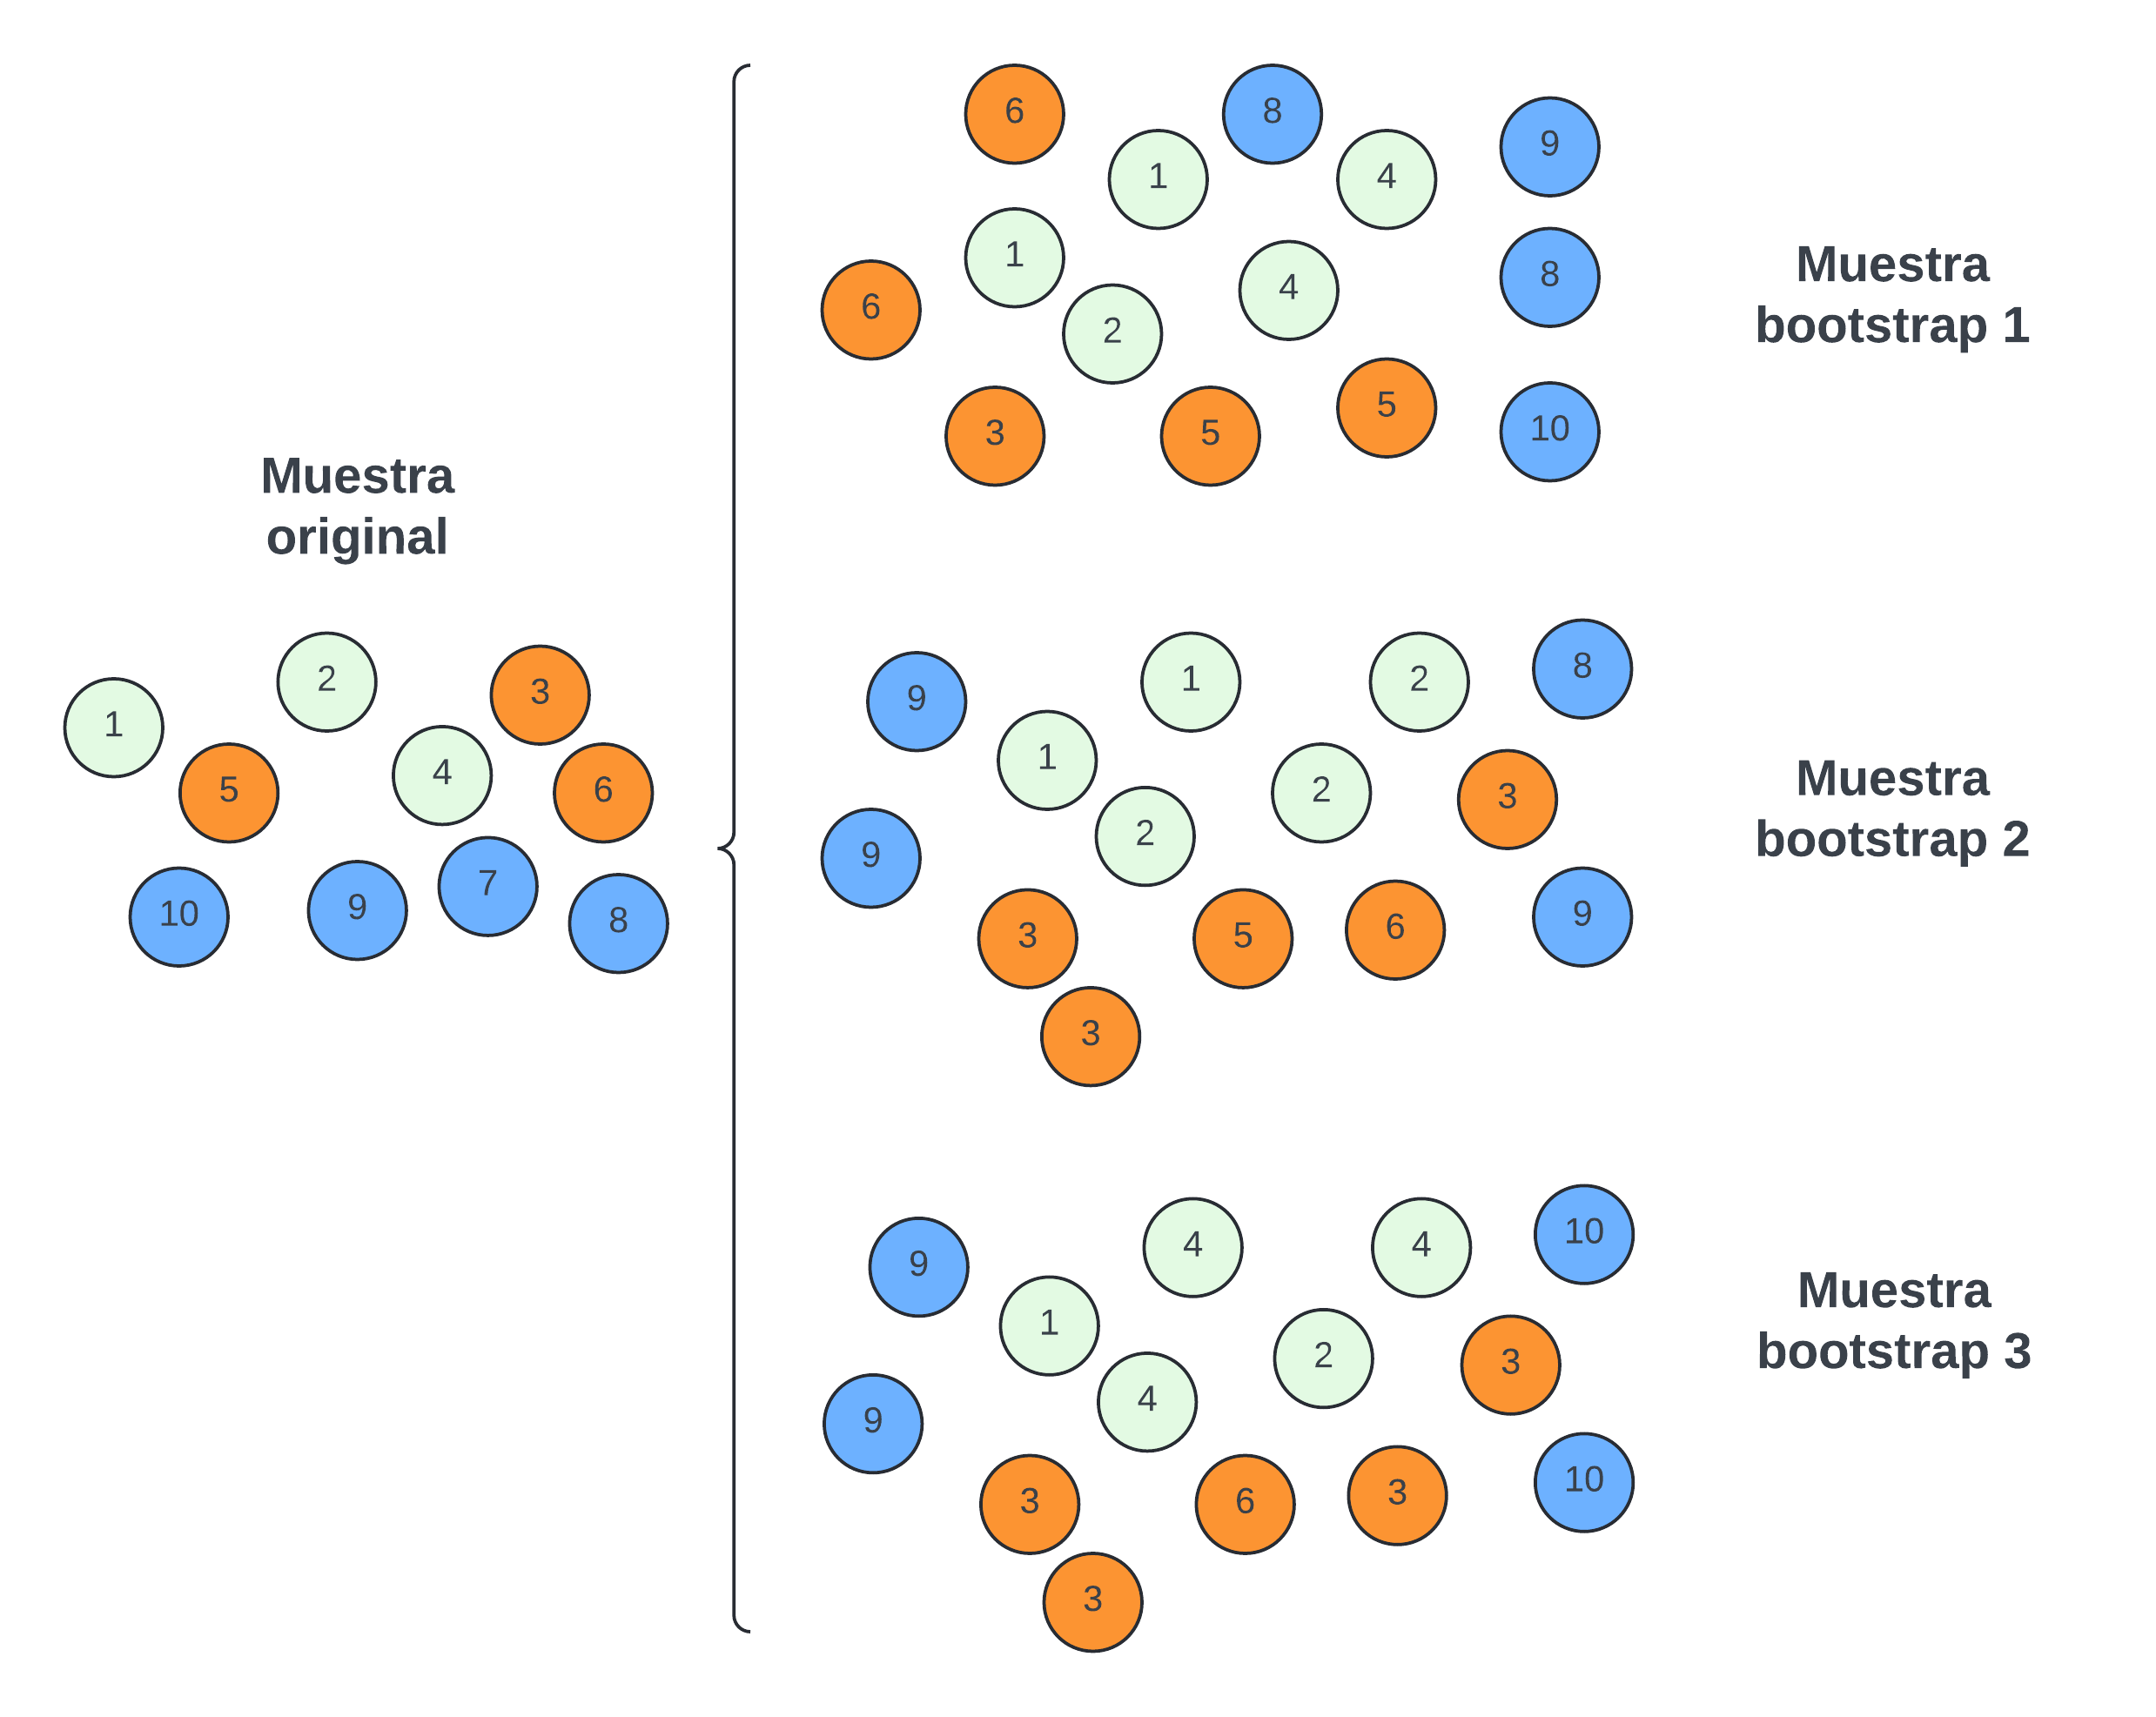

In [66]:
from IPython.display import Image
Image(filename='./Bootstrap.png') 

Como se aprecia en la imagen anterior, disponemos de una muestra de 10 elementos, con tres elementos del color verde claro, tres elementos naranja, y cuatro elementos azules. Al hacer las muestras bootstrap notamos como se duplican elementos de la muestra original, la primera muestra bootstrap tiene dos veces el elemento 6 (naranjo), dos veces el elemento 5 (naranjo), dos veces los elementos 1 y 4 (verde claro), y dos veces el elemento 8 (azul). De esta forma aumentamos el tamaño aplicando reemplazo de elementos desde el conjunto de datos original.

Entendiendo esto podemos introducir el concepto de bagging. Supongamos que tenemos un modelo que realiza alguna tarea de clasificación o regresión, si el modelo es bueno, ¿mejorará el desempeño tener muchos más modelos trabajando en conjunto? Esta idea se muestra en la imagen a continuación

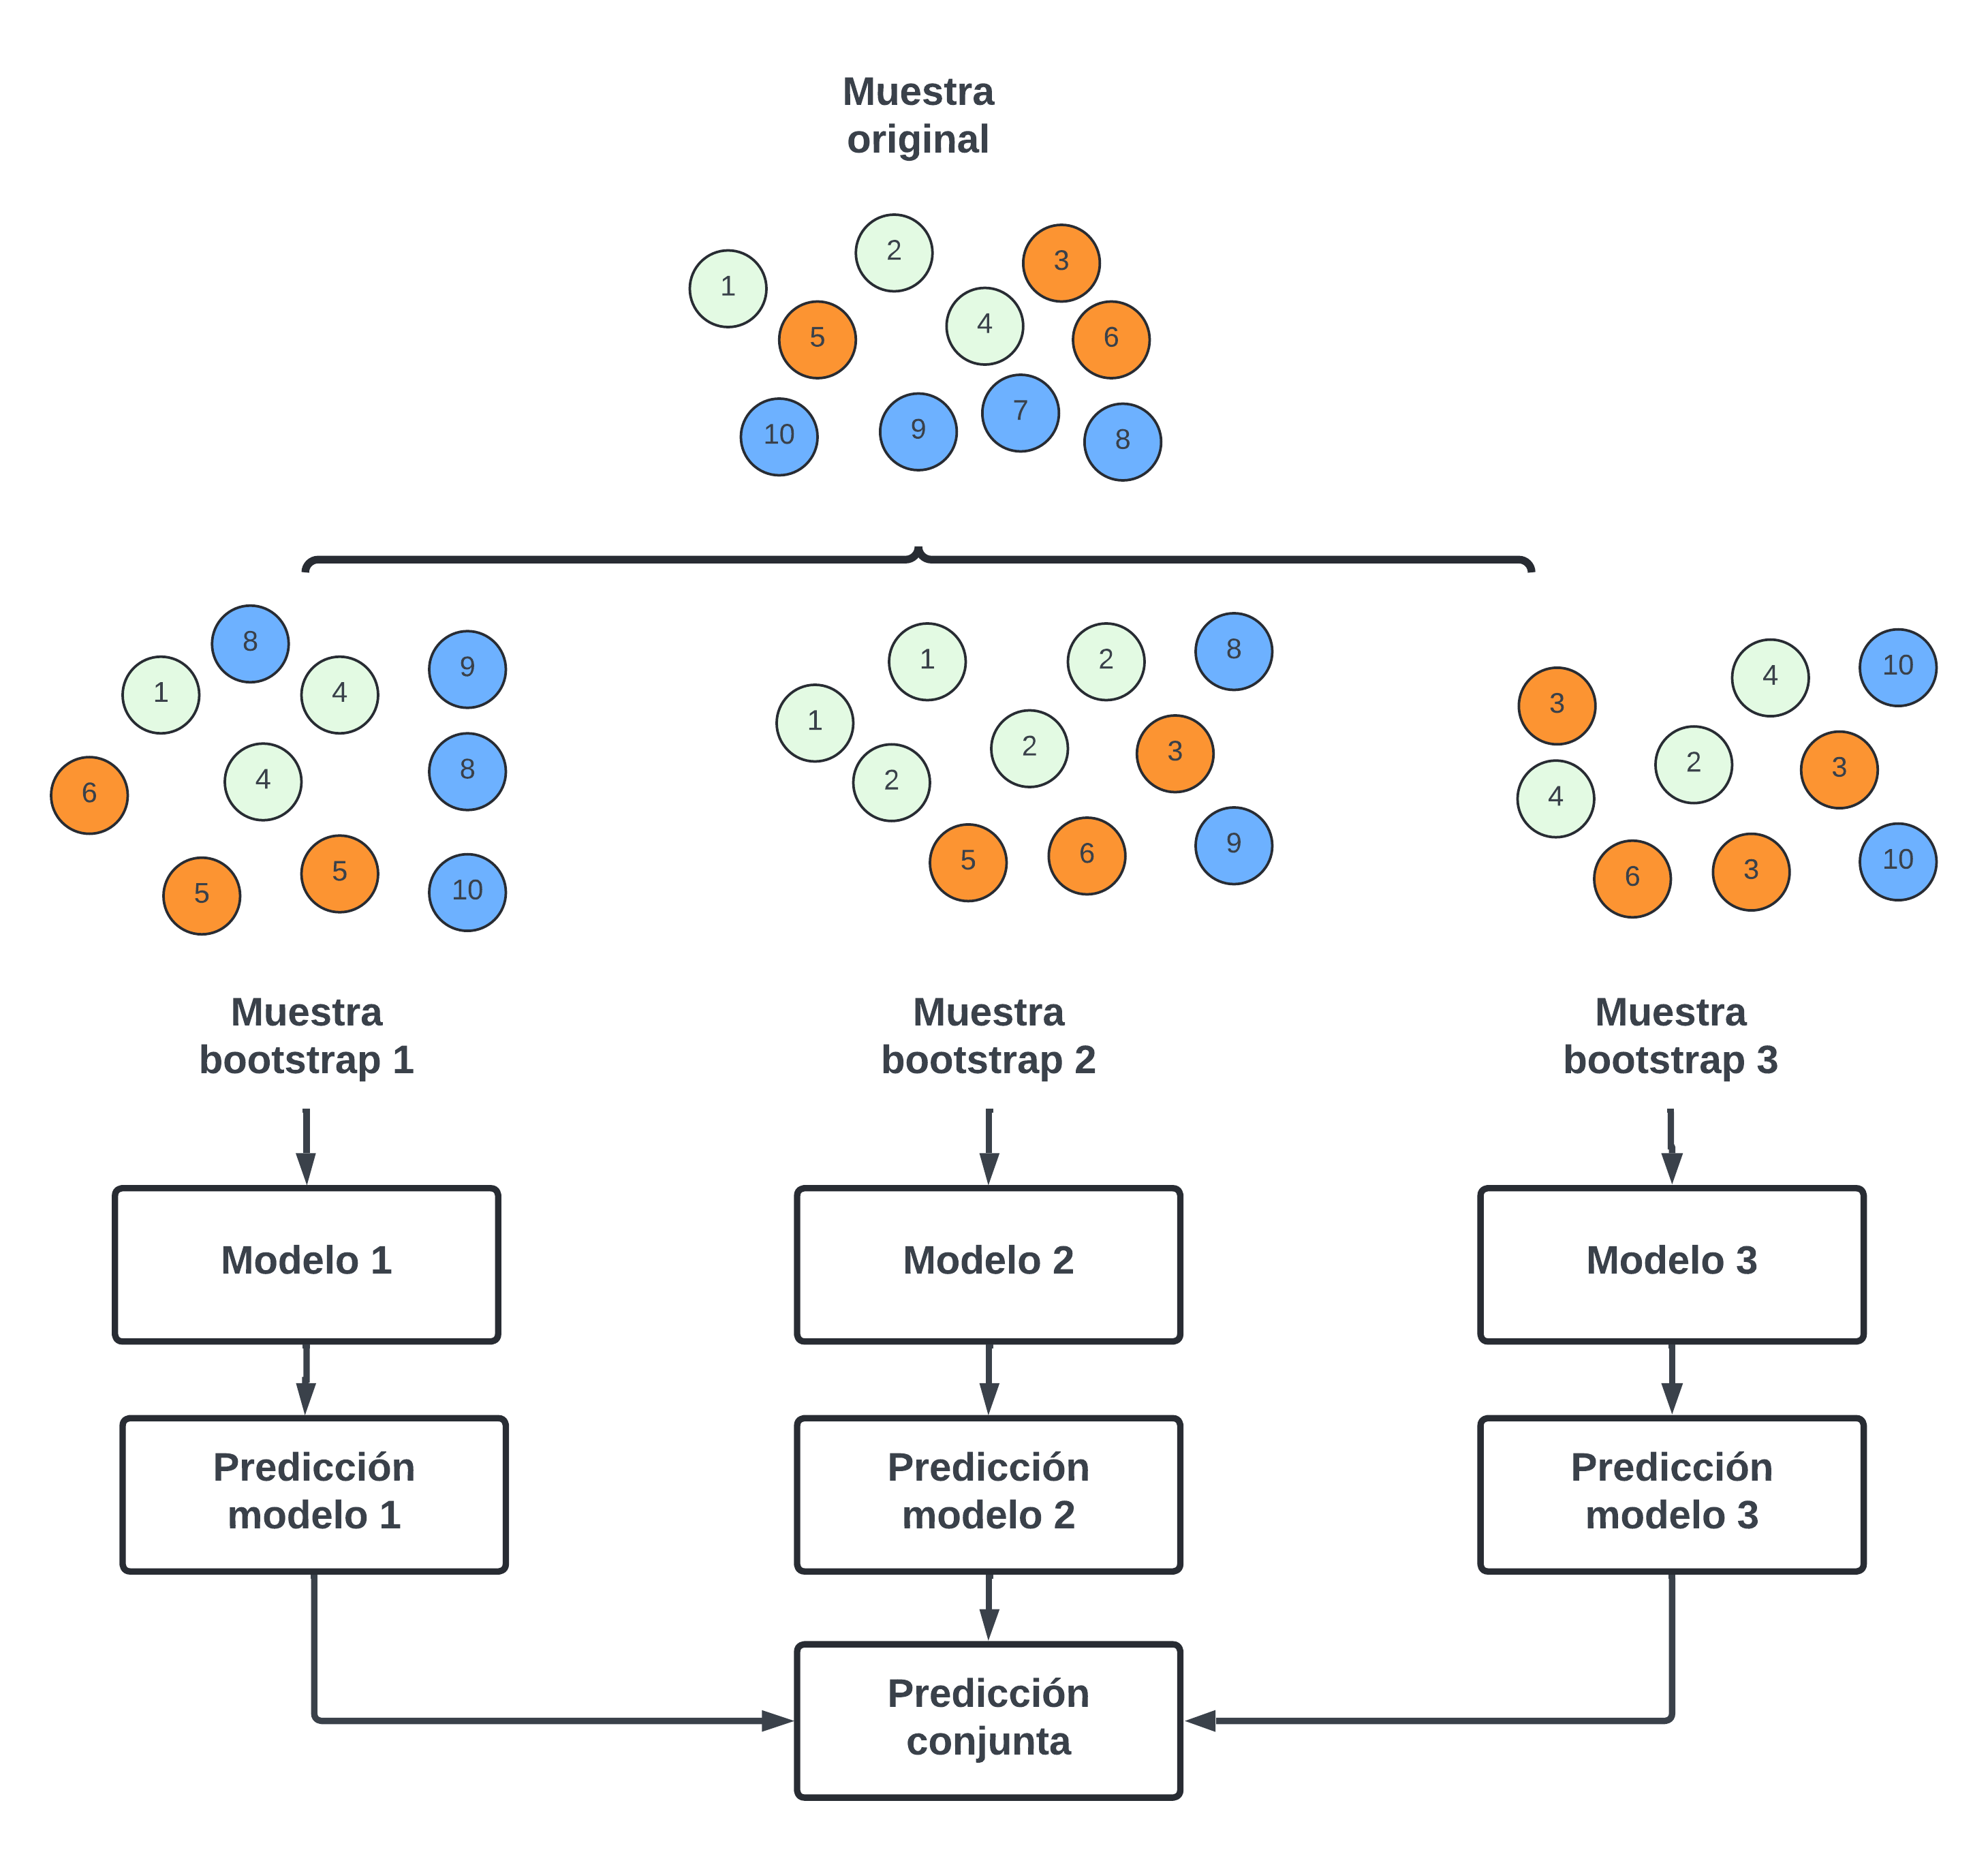

In [67]:
Image(filename='./Bagging.png') 

Ahora vamos a construir nuestro modelo y comparar respecto a los modelos base, para esto primero se ajusta un arbol de decisión (bien básico sin ajuste de parámetros ni nada), y luego se compara ese modelo básico en un bagging.

In [41]:
# Dependencias necesarias

# Carga de datos desde UCI ML repository
from ucimlrepo import fetch_ucirepo 
# División del conjunto de datos en entrenamiento y testeo
from sklearn.model_selection import train_test_split
# Funciones de numpy varias
import numpy as np
# Modelo base a repetir para el bagging
from sklearn.tree import DecisionTreeRegressor
# Métricas de desempeño para la regresión
from sklearn.metrics import r2_score, mean_absolute_percentage_error
# Funciones de pandas varias
import pandas as pd
# Gráficos
import matplotlib.pyplot as plt

In [42]:
dataset = fetch_ucirepo(id=165) # El id 165 tiene el set que vamos a utilizar

# data (as pandas dataframes) 
X = dataset.data.features 
y = dataset.data.targets

In [43]:
# Árbol de decisión único

# Separamos en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

regr_1 = DecisionTreeRegressor()
regr_1.fit(X_train, y_train)

y_pred = regr_1.predict(X_test)

print('R2 Score:', np.round(r2_score(y_test, y_pred),2))
print('MAPE:', np.round(mean_absolute_percentage_error(y_test, y_pred), 2))

R2 Score: 0.77
MAPE: 0.15


Text(0.5, 1.0, 'Decision Tree Regressor')

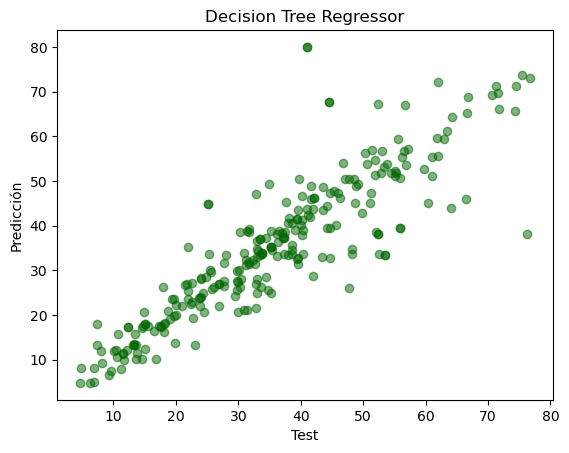

In [58]:
plt.scatter(y_test, y_pred, marker = 'o', alpha = 0.5, c = 'darkgreen')
plt.xlabel('Test')
plt.ylabel('Predicción')
plt.title('Decision Tree Regressor')

En lo anterior notamos que el arbol de decisión muestra un R2 de 77%, junto con un MAPE de 15%. Ambas métricas son buenas, pero veamos si a través de bagging obtenemos algo mejor juntando muchos modelos base como este.

Para realizar el bagging generamos una función que permite crear una cantidad definidad por el usuario de modelos (argumento N_arboles). La función tiene la siguiente estructura.

- Crea un objeto lista vacío que llenará con los arboles creados en un loop.
- Extra los índices desde el conjunto de entrenamiento con los que hará el muestreo bootstrap
- En cada iteración crea un árbol de decisión que entrena con muestras bootstrap del conjunto de entrenamiento (X e Y).
- Junta todos estos objetos en la lista generada al principio y devuelve ese elemento desde la función

In [45]:
def create_random_forest(N_arboles):
    
    objs = list() # Lista vacía para guardar los modelos
    indices = X_train.index # índices para muestrear

    # Inicio del loop
    for i in range(N_arboles):
        regr = DecisionTreeRegressor() # Generamos un modelo de árbol de decisión en cada iteración desde cero
        # Muestreo bootstrap desde los índices del conjunto de entrenamiento, notar que tiene un replace = TRUE lo que permite tener reemplazos en las muestras
        # Este reemplazo hace que se repitan elementos en cada iteración generada
        # La función que genera esto es de numpy, específicamente random.choice
        indices_bagging = np.random.choice(indices, size = len(indices), replace = True)

        # Ajustamos el modelo de arbol para el caso particular con el conjunto de entrenamiento re-muestreado (mediante bootstrapping) para X e Y
        regr.fit(X_train[X_train.index.isin(indices_bagging)],
                 y_train[y_train.index.isin(indices_bagging)])
        # Agregamos el modelo ajustado a la lista de modelos
        objs.append(regr)
        
    return(objs)   

La predicción la realizamos con la agregación de todas las predicciones individuales de todos los modelos ajustados en la función anterior, la imagen a continuación ilustra este proceso (de una forma bastante rara, pero espero se entienda)

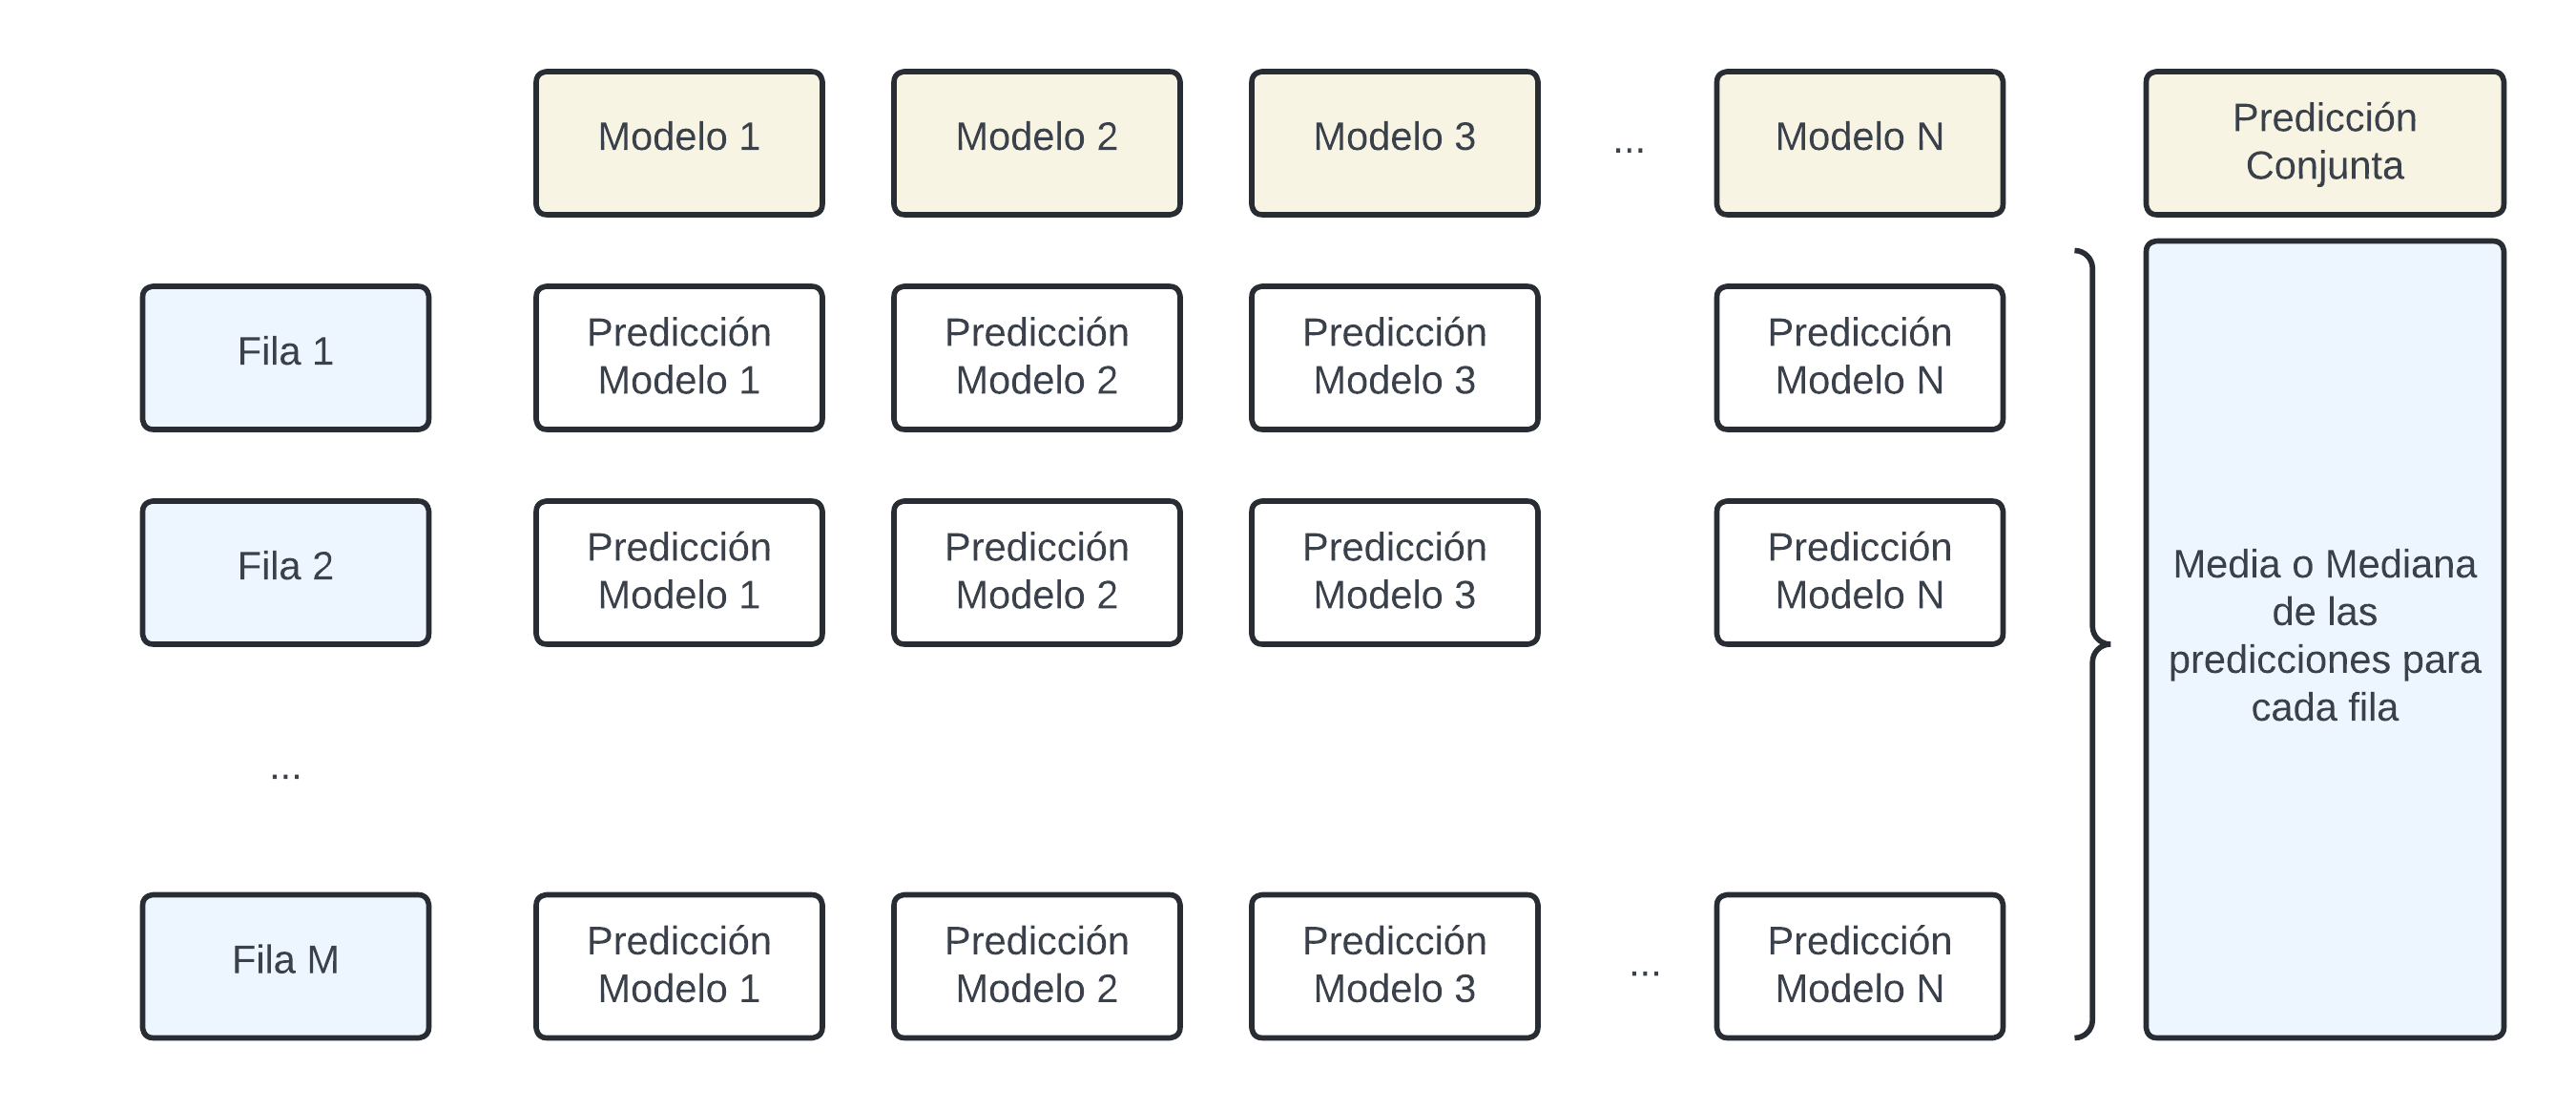

In [68]:
Image(filename='./Tabla predicción.png') 

In [46]:
def prediccion_arbol(test, model, metric):

    data = [] # Lista vacía para guardar las predicciones
    for i in range(len(model)): # Para cada modelo realizamos la predicción en el conjunto de testeo
        y_pred = model[i].predict(test)
        data.append(y_pred) # Guardamos las predicciones en la lista generada anteriormente
    data = pd.DataFrame(data) # Manejo de datos para que devuelva una forma tabular
    data = np.transpose(data) # Traspuesta para hacer operaciones row-wise

    # Agregamos dos formas de obtener predicciones
    # Uno a través del promedio de las filas y otro a través de la mediana de las predicciones de las filas
    if metric == 'mean':
        y_pred = data.mean(axis=1)
    elif metric == 'median':
        y_pred = data.median(axis=1)
        
    return(y_pred)

In [47]:
# Generamos un modelo con 100 árboles
modelos = create_random_forest(N_arboles=100)

In [59]:
# Predicciones con el promedio

y_pred_mean = prediccion_arbol(test = X_test, model = modelos, metric = 'mean')

print('R2 Score: ', r2_score(y_test, y_pred_mean))

print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred_mean))

R2 Score:  0.8852468105731551
MAPE:  0.12827625026963863


Text(0.5, 1.0, 'Modelo Bagging - promedio de las predicciones')

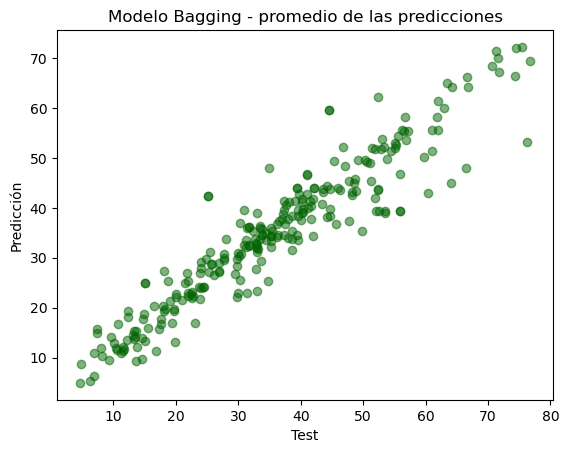

In [56]:
plt.scatter(y_test, y_pred_mean, marker = 'o', alpha = 0.5, c = 'darkgreen')
plt.xlabel('Test')
plt.ylabel('Predicción')
plt.title('Modelo Bagging - promedio de las predicciones')

In [52]:
y_pred_median = prediccion_arbol(test = X_test, model = modelos, metric = 'median')

print('R2 Score: ', r2_score(y_test, y_pred_median))

print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred_median))

R2 Score:  0.8797685810716338
MAPE:  0.11899490217652992


Text(0.5, 1.0, 'Modelo Bagging - mediana de las predicciones')

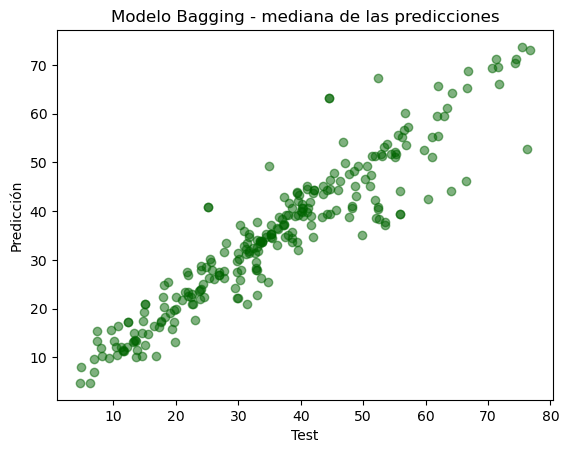

In [60]:
# Predicciones con la mediana

plt.scatter(y_test, y_pred_median, marker = 'o', alpha = 0.5, c = 'darkgreen')
plt.xlabel('Test')
plt.ylabel('Predicción')
plt.title('Modelo Bagging - mediana de las predicciones')

En lo anterior obtenemos las predicciones para un modelo de bagging consistente de 100 árboles de decisión generados mediante muestras bootstrap. Además de esto realizamos predicciones utilizando el promedio y la mediana de las predicciones individuales, para el caso del promedio el R2 es de 88.52% superior al 87.97% presentado por la predicción con la mediana, lo contrario ocurre con el MAPE, donde el realizar una predicción con la mediana de las predicciones individuales arroja un error de 11.89% menor al 12.83% del promedio.

En ambos casos el desempeño es mejor que el arbol de decisión que habíamos entrenado en un principio (R2 = 77% y MAPE = 15%). Esto se podría ampliar realizando optimización sobre el árbol inicial o definiendo otras métricas para la predicción conjunta (ni hablar de validación cruzada) (recordar que esto es básico y sencillo)